<bold><font size="6">Transfer Learning Tremor Location (TL): Tutorial</font></bold>
# Introduction

In this jupyter notebook we show how to use the `tl` package. This is how you import it:

In [1]:
import tl

Our study case is the tremor from the Kilauea summit caldera collapse in 2018. For the sake of technical illustration, we use a minimal working example. The results are not satisfying since the training and prediction data sets are very small. Nonetheless, this example can be modified to run with the full dataset and reproduce the results presented in van der Laat et al. (2023).

## yaml configuration file

This file contains all the user-defined parameters that you can modify. We will modify and explain it along the way.

## Command-line programs

For every main step in this analysis we use command-line programs. If you were in your console and the installation of this package was succesful, you would be able to run it using a command like the following:

    $ tl-[PROGRAM] config.yml

Since we are in a jupyter notebook we will be appending a `!` in front of command lines or using the command

    %run ../bin/tl-[PROGRAM] config.yml

For each program a different set of parameters in the configuration file is used. To know which parameters are being used in a particular program run this command line:

    $ tl-help [PROGRAM]
    
For example:

In [2]:
!tl-help feature_extraction_tremor

zsh:1: command not found: tl-help


The options for `tl-help` can be printed by using this command:

In [3]:
!tl-help -h

zsh:1: command not found: tl-help


## Cartesian projection

The tl package works with cartesian coordinates. [Find out your EPSG code](https://epsg.io/). For this example, we use the [NAD83 / Hawaii zone 1](https://epsg.io/26961) projection with the code `26961`. In the configuration file

```yaml
projection:
    epsg: 26961
```

## Seismic stations
### `STATIONXML` response file

Let's first obtain our inventory from the IRIS-DMC and write it to a file for later use:

In [2]:
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime

client = Client('IRIS')

inventory = client.get_stations(
    starttime=UTCDateTime(2018, 1, 1),
    endtime=UTCDateTime(2019, 1, 1),
    network='HV',
    channel='EH*,HH*',
    minlatitude=19.3270,
    maxlatitude=19.4704,
    minlongitude=-155.3339,
    maxlongitude=-155.1631,
    level='channel'
)

inventory.write('inventory.xml', format='STATIONXML')

Annotate the path to this file in your configuration file:

```yaml
preprocess:
    inventory: inventory.xml
```

### Stations `CSV` file
For user easy network configuration we convert the STATIONXML file to a simple dataframe:

In [3]:
df = tl.inventory.to_dataframe(inventory)

In this case we won't use stations `NAHU` and `NPT`:

In [6]:
df = df[~df.station.isin(['NAHU', 'NPT'])]

We also perform the transformation of the coordinate system:

In [6]:
import warnings
warnings.filterwarnings('ignore')

df['x'], df['y'] = tl.projection.geographic_to_cartesian(
    df.longitude.values, df.latitude.values, 26961
)
df.reset_index(inplace=True)
df

,index,network,station,channel,longitude,latitude,z,x,y
0,0,HV,AHUD,EHE,-155.263462,19.371567,1051.0,524848.012953,59592.976092
1,1,HV,AHUD,EHN,-155.263462,19.371567,1051.0,524848.012953,59592.976092
2,2,HV,AHUD,EHZ,-155.263462,19.371567,1051.0,524848.012953,59592.976092
3,3,HV,BYL,HHE,-155.259872,19.412086,1079.0,525218.906428,64078.741166
4,4,HV,BYL,HHN,-155.259872,19.412086,1079.0,525218.906428,64078.741166
5,5,HV,BYL,HHZ,-155.259872,19.412086,1079.0,525218.906428,64078.741166
6,6,HV,CPKD,EHZ,-155.324317,19.391443,1038.0,518452.706814,61785.625287
7,7,HV,DEVL,HHE,-155.240608,19.373568,1046.0,527248.588901,59817.880035
8,8,HV,DEVL,HHN,-155.240608,19.373568,1046.0,527248.588901,59817.880035
9,9,HV,DEVL,HHZ,-155.240608,19.373568,1046.0,527248.588901,59817.880035


Let's write the dataframe to a `csv` file:

In [9]:
df.to_csv('channels.csv', index=False)

Annotate the path to this file in your configuration file:

```yaml
features:
    channels_csv: channels.csv
```

## Earthquake catalog

This package uses a catalog formatted as a `csv` file as following:

| time | latitude | longitude | depth | magnitude | eventid |
| ---- | -------- | --------- | ----- | --------- | ------- |
| 2018-04-29 01:24:11.320 | 19.40776 | -155.29421 | 2.465 | 0.64 | 42905052 |

In this case we used the catalog genereted by [Shelly and Thelen (2019)](https://doi.org/10.1029/2019GL085636). We already downloaded and converted this catalog to the `catalog.csv` file in this directory. In this catalog the reference for the depth is the summit elevation (~1.2 km). We corrected to obtain a sea level reference.

Annotate the path to this file in your configuration file:

```yaml
dataset:
    catalog: catalog.csv
    magnitude_min: 1
    magnitude_max: 5
    n_events: 200
```
In this section of the configuration file you can control how the filter the catalog. In this example we use a small number of events.

# Synthetic tests
We run a synthetic test in order to have an idea of how well this dataset in combination with the network configuration can do for our purposes.

2022-08-26 18:43:39,721 - root - INFO - n=100, n(train)=70, n(test)=30
2022-08-26 18:43:39,721 - root - INFO - n=100, n(train)=70, n(test)=30
2022-08-26 18:43:39,727 - root - INFO - Test error: 37 m
2022-08-26 18:43:39,727 - root - INFO - Test error: 37 m
2022-08-26 18:43:39,728 - root - INFO - Standard deviation (xyz): [  8  10 176] m
2022-08-26 18:43:39,728 - root - INFO - Standard deviation (xyz): [  8  10 176] m
2022-08-26 18:43:39,729 - root - INFO - Prediction interval (xyz): [ 17  20 345] m
2022-08-26 18:43:39,729 - root - INFO - Prediction interval (xyz): [ 17  20 345] m
2022-08-26 18:43:40,553 - root - INFO - Total error: 0 m
2022-08-26 18:43:40,553 - root - INFO - Total error: 0 m
2022-08-26 18:43:40,554 - root - INFO - Standard deviation (xyz): [0 0 0] m
2022-08-26 18:43:40,554 - root - INFO - Standard deviation (xyz): [0 0 0] m
2022-08-26 18:43:40,555 - root - INFO - Prediction interval (xyz): [0 0 0] m
2022-08-26 18:43:40,555 - root - INFO - Prediction interval (xyz): [0 0

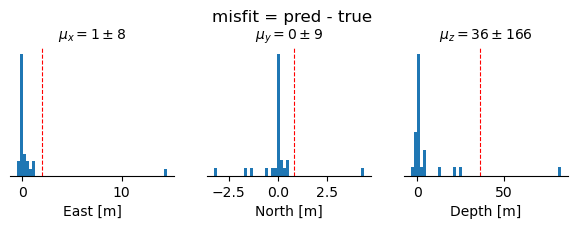

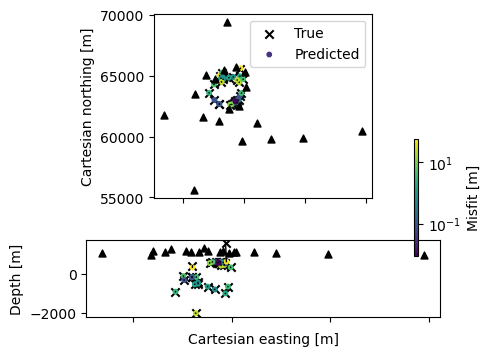

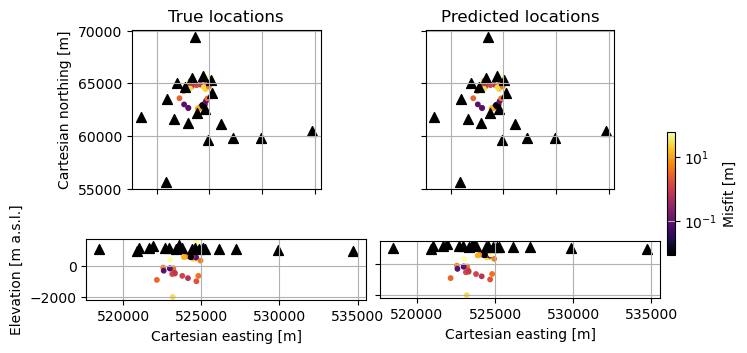

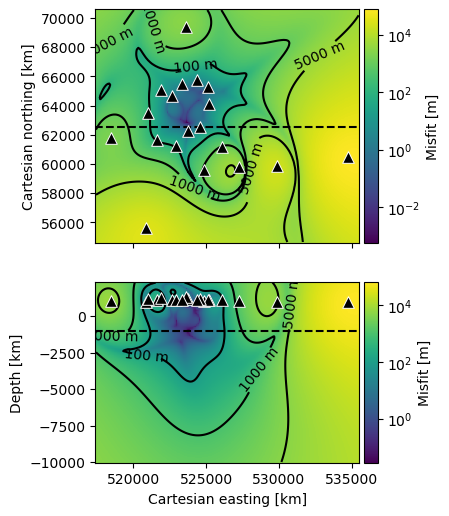

In [7]:
%run ../bin/tl-synth config.yml